**This code will work only in colab, please add object_recogntion file under main path of your drive**

[guide link](https://towardsdatascience.com/detailed-tutorial-build-your-custom-real-time-object-detector-5ade1017fd2d)

In [1]:
from google.colab import drive
 
drive.mount('/gdrive')
# the project's folder
%cd /gdrive/'My Drive'/object_detection

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/object_detection


In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==1.15.0
!git clone --q https://github.com/tensorflow/models.git
!pip install tf_slim

In [3]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile

import tensorflow.compat.v1 as tf

import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files



# compils the proto buffers
# exports PYTHONPATH environment var with research and slim paths


In [7]:
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.
os.environ['PYTHONPATH'] += ':./:./slim/'

/gdrive/My Drive/object_detection/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [11]:
!python object_detection/builders/model_builder_test.py

2020-06-17 09:50:45.416303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


# Let’s start with selecting a pretrained model:

[models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models)

In [12]:
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
    },
}

# Select a model from `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'

In [21]:
#the distination folder where the model will be saved
#change this if you have a different working dir
DEST_DIR = '/gdrive/My Drive/object_detection/models/research/pretrained_model'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#checks if the model has already been downloaded, download it otherwise
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the model and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

In [29]:
!cat object_detection/samples/configs/ssd_mobilenet_v2_coco.config



# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspec

In [24]:
%%writefile object_detection/samples/configs/ssd_mobilenet_v2_coco.config


# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.99
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 24
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.004
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "/gdrive/My Drive/object_detection/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "/gdrive/My Drive/object_detection/data/train.record"
  }
  label_map_path: "/gdrive/My Drive/object_detection/data/label_map.pbtxt"
}

eval_config: {
  num_examples: 400
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 20
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/gdrive/My Drive/object_detection/data/test.record"
  }
  label_map_path: "/gdrive/My Drive/object_detection/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [25]:
!pwd

/gdrive/My Drive/object_detection/models/research


In [26]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
#the logs that are created while training 
LOG_DIR = "training/"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
#The link to tensorboard.
#works after the training starts.
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-06-17 10:39:31--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.204.235.107, 52.22.244.167, 3.220.228.61, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.204.235.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  29.2MB/s    in 0.4s    

2020-06-17 10:39:31 (29.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://e06d639a34bd.ngrok.io


# train model

In [35]:
!python object_detection/model_main.py \
    --pipeline_config_path=/gdrive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir=training/

W0617 11:01:39.699920 140576567818112 model_lib.py:717] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I0617 11:01:39.700213 140576567818112 config_util.py:523] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0617 11:01:39.700349 140576567818112 config_util.py:523] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0617 11:01:39.700489 140576567818112 config_util.py:523] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0617 11:01:39.700628 140576567818112 config_util.py:523] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
I0617 11:01:39.700762 140576567818112 config_util.py:523] Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
I0617 11:01:39.700920 140576567818112 config_util.py:5

# **save model**

In [36]:
output_directory = './fine_tuned_model'

lst = os.listdir('training')
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join('training', last_model)

In [ ]:
!python /gdrive/'My Drive'/object_detection/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/gdrive/My\ Drive/object_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

# Test

In [79]:
%cd /gdrive/'My Drive'/object_detection/models/research

/gdrive/My Drive/object_detection/models/research


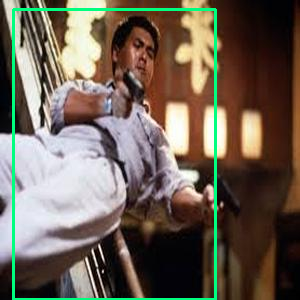

In [102]:
%matplotlib inline 

import numpy as np
import os
import tensorflow as tf
import cv2
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from IPython.display import Image, display
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# path to the frozen graph:
PATH_TO_FROZEN_GRAPH = '/gdrive/My Drive/object_detection/models/research/pretrained_model/frozen_inference_graph.pb'

# path to the label map
PATH_TO_LABEL_MAP = '/gdrive/My Drive/object_detection/data/label_map.pbtxt'

# path to image test
PATH_TO_IMAGES_TEST = "/gdrive/My Drive/object_detection/data/testImages"
# number of classes 
NUM_CLASSES = 1


#reads the frozen graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABEL_MAP)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
          image_np = cv2.imread(PATH_TO_IMAGES_TEST+"/0002.jpeg")
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
          image_np_expanded = np.expand_dims(image_np, axis=0)
          # Extract image tensor
          image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
          # Extract detection boxes
          boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
          # Extract detection scores
          scores = detection_graph.get_tensor_by_name('detection_scores:0')
          # Extract detection classes
          classes = detection_graph.get_tensor_by_name('detection_classes:0')
          # Extract number of detections
          num_detections = detection_graph.get_tensor_by_name(
              'num_detections:0')
          # Actual detection.
          (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
          # Visualization of the results of a detection.
          vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=3,
              )
      # Display output
          cv2_imshow(image_np)
          cv2.imwrite("/gdrive/My Drive/object_detection/data/resultImages/test.jpg",image_np)